In [467]:
import numpy as np
from scipy.optimize import minimize, least_squares

In [468]:
from typing import Callable, Tuple, List
import pandas as pd

In [469]:
import random

In [470]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 22

In [471]:
EPS = 1e-3

In [472]:
def plot_line(f: Callable[[float], float], ranges: Tuple[float, float], min_x: float, title: str):
    X = np.linspace(ranges[0][0], ranges[0][1], 1000)
    plt.plot(X, [f(x) for x in X])
    plt.plot([min_x], [f(min_x)], marker='o', markersize=3, color="red")  
    plt.title(title)
    plt.show()

In [473]:
def plot_scatter_with_trends(x: List[float], y: List[float], trends: List[Tuple[List[float], List[float], str]], title: str):
    plt.scatter(x, y, label="generated data")
    for x, y, label in trends:
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

In [474]:
def run_minimize(method: str, 
                 f: Callable[[float], float], 
                 jac: Callable[[float], float],
                 ranges: List[Tuple[float, float]], tol: float) -> Tuple[float, int]:
    x0 = [random.uniform(low, hight) for low, hight in ranges]
    res = minimize(method=method, fun=f, x0=x0, bounds=ranges, tol=tol, jac=jac)
    return res.x, res.nit

In [475]:
def run_least_squares(method: str, 
                      f: Callable[[float], float],
                      jac: Callable[[float], float],
                      ranges: List[Tuple[float, float]], tol: float) -> Tuple[float, int]:
    x0 = [random.uniform(low, hight) for low, hight in ranges]
    res = least_squares(method=method, fun=f, x0=x0, xtol=tol)
    return res.x, res.nfev

In [476]:
def run_gradient_descent(method: str, 
                        f: Callable[[float], float],
                        jac: Callable[[float], float],
                        ranges: List[Tuple[float, float]], 
                        tol: float, learning_rate = 1e-1, max_epochs = 1e7) -> Tuple[float, int]:
    x0 = [random.uniform(low, hight) for low, hight in ranges]
    it = 0
    while it < max_epochs:
        it += 1
        delta = learning_rate * jac(x0)
        if np.all(np.abs(delta) < tol):
            break
        x0 -= delta
        
    return x0, it

In [477]:
methods = [('CG', run_minimize), 
           ('Newton-CG', run_minimize), 
           ('lm', run_least_squares),
           ('GD', run_gradient_descent)]

In [478]:
def run_f(f: Callable[[float], float], x: float, inv: List[int]) -> float:
    inv[0] += 1
    return f(x)

In [479]:
def run_optimization(optimizer, 
                     method: str,
                     f: Callable[[float], float], 
                     jac: Callable[[float], float],
                     ranges: List[Tuple[float, float]], tol: float) -> Tuple[float, int, int]:
    inv = [0]
    opt, it = optimizer(method, lambda x: run_f(f, x, inv), jac, ranges, tol)
    return opt, it, inv[0]

In [480]:
N = 100
alpha, beta = random.uniform(0, 1), random.uniform(0, 1)
x = np.array([k / 100 for k in range(N)])
y = alpha * x + beta + np.random.normal(0, 1, N)

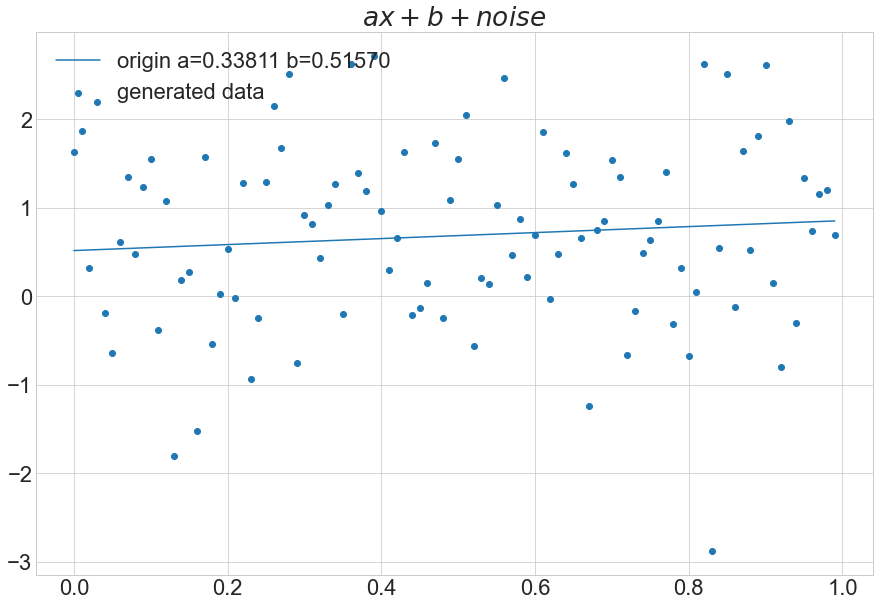

In [481]:
plot_scatter_with_trends(x, y, [(x, alpha * x + beta, "origin" + (" a=%.5f b=%.5f" % (alpha, beta)))], '$ax + b + noise$')

In [482]:
def d(f, a, b, x, y):
    return (np.square(f(x, a, b) - y)).mean(axis=0)

def d_jac(f, f_jac, a, b, x, y):
    d_df = np.full(x.shape, 2 * (f(x, a, b) - y))
    df = f_jac(x, a, b)
    return np.array([(d_df * df[0]).mean(axis=0), (d_df * df[1]).mean(axis=0)])

In [483]:
def minimize_multidimensional_function(f_: Callable[[float, float, float], float], 
                                       f_jac_: Callable[[float, float, float], float],
                                       f_ranges: List[Tuple[float, float]], f_name: str) -> pd.DataFrame:
    
    results = []
    trends = [(x, alpha * x + beta, "origin")]
    
    for method, optimizer in methods:
        if method == 'lm':
            f = lambda p: f_(x, p[0], p[1]) - y
            jac = lambda p: f_jac_(x, p[0], p[1])
        else:
            f = lambda p: d(f_, p[0], p[1], x, y)
            jac = lambda p: d_jac(f_, f_jac_, p[0], p[1], x, y)
            
        opt, it, inv = run_optimization(optimizer, method, f, jac, f_ranges, EPS)
        mse = d(f_, opt[0], opt[1], x, y)
        results.append([f'${f_name}$', method, f_ranges, np.around(opt, 5), mse, it, inv])
        trends.append((x, f_(x, opt[0], opt[1]), method))
    
    plot_scatter_with_trends(x, y, trends, f_name)
    df = pd.DataFrame.from_records(results, columns=['function', 'method', 'range', '[a, b]', 'mse', 'iteratins', 'invocations'])
    return df

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_5644/2148284058.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x, 1])
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


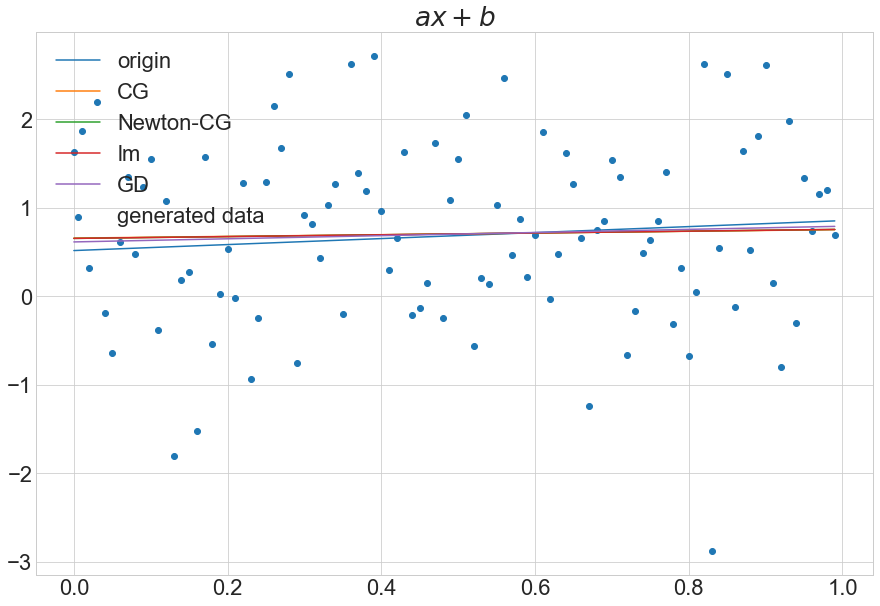

,function,method,range,"[a, b]",mse,iteratins,invocations
0,$$ax + b$$,CG,"[[0, 1], [0, 1]]","[0.09644, 0.65629]",1.074899,6,11
1,$$ax + b$$,Newton-CG,"[[0, 1], [0, 1]]","[0.10225, 0.65295]",1.074896,3,4
2,$$ax + b$$,lm,"[[0, 1], [0, 1]]","[0.10225, 0.65295]",1.074896,7,14
3,$$ax + b$$,GD,"[[0, 1], [0, 1]]","[0.17719, 0.61324]",1.075371,71,0


In [484]:
def f1(x, a, b):
    return a * x + b

def f1_jac(x, a, b):
    return np.array([x, 1])

functin = (f1, f1_jac, [[0, 1], [0, 1]], '$ax + b$')
minimize_multidimensional_function(*functin)

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


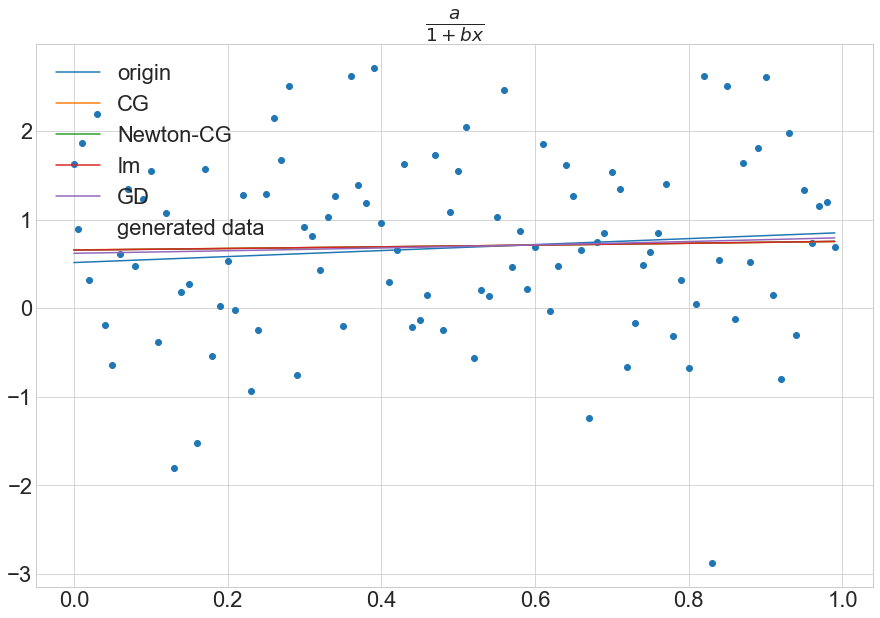

,function,method,range,"[a, b]",mse,iteratins,invocations
0,$$\frac{a}{1 + bx}$$,CG,"[[-1, 1], [-1, 1]]","[0.6587, -0.1264]",1.074926,7,15
1,$$\frac{a}{1 + bx}$$,Newton-CG,"[[-1, 1], [-1, 1]]","[0.65676, -0.13135]",1.074925,5,6
2,$$\frac{a}{1 + bx}$$,lm,"[[-1, 1], [-1, 1]]","[0.65676, -0.13135]",1.074925,30,37
3,$$\frac{a}{1 + bx}$$,GD,"[[-1, 1], [-1, 1]]","[0.62042, -0.22078]",1.075425,124,0


In [485]:
def f2(x, a, b):
    return a / (1 + x * b)

def f2_jac(x, a, b):
    return np.array([1.0 / (1 + x * b), - x * a / ((1 + x * b) ** 2)])

fuction = (f2, f2_jac, [[-1, 1], [-1, 1]], r'$\frac{a}{1 + bx}$')
minimize_multidimensional_function(*fuction)